# f-AnoGAN in Pytorch 

#### - Fast unsupervised anomaly detection with generative adversarial networks (GAN)

#### - Suitable for **real-time** anomaly detection applications.

#### - We build a generative model of healthytraining data, and propose and evaluate a fast mapping technique of new data to the GAN’s latent space.
#### - The mapping is based on a trained encoder, and anomalies are detected via a combined anomaly scorebased on the building blocks of the trained model – comprising a discriminator feature residual error andan image reconstruction error.
#### - Only for data selection prior to training, large dataset is needed on this technique
#### - We present an in-depth study of diﬀerent encoder training approaches, the “latent regressor” architecture, az-to-z mapping (ziz) procedure known from literature (Donahue et al., 2016), and beyond that two newimage-to-image (izi) mapping approaches. Encoder training for mapping images to latent vectors needsa pre-trained GAN. We use a WGAN, a state-of-the-art GAN, architecture. 
#### - (izi architecture follows a standard AE conﬁguration, where an encoder is followed by a decoder(generator))
#### - However, our proposedapproach is not limited to WGAN training but can be applied to any pre-trained GAN

##### Paper URL: https://www.sciencedirect.com/science/article/abs/pii/S1361841518302640
##### PDF: https://arxiv.org/pdf/1905.11034.pdf

##### - From "https://github.com/mulkong/f-AnoGAN_with_Pytorch?fbclid=IwAR245G6hlBo0sU-CW_q1nrDym-KNKADP5_3n_uY2IJmmTuPonkHzs0_PI3g"
##### - From "https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/wgan_gp/wgan_gp.py"

## 1. Load Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import autograd, optim
from torch.utils.data import DataLoader, Dataset

import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
from torchvision.utils import save_image
from tensorboardX import SummaryWriter

torch.manual_seed(0)
np.random.seed(0)
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.determinstic = False

writer = SummaryWriter(logdir='runs/GAN_training')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import os
import time

import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import random
import matplotlib.pyplot as plt
%matplotlib inline    

In [22]:
SEED = 623
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

In [21]:
# Shows torch.tensor which is in dataloader 
def imshow_grid(img):
    img = torchvision.utils.make_grid(img.cpu().detach())
    img_numpy = img.numpy()
    print(img_numpy.shape)
    plt.figure(figsize=(10, 20))
    plt.imshow(np.transpose(img_numpy, (1, 2, 0)))
    plt.show()

## 2. Model Architecture (DCGAN)

### 2.1 Generator

In [7]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100, ngf = 28, channels=1, bias = True):
        super().__init__()
        
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, ngf*4, kernel_size=4, stride=1, padding=0, bias=bias),
            nn.BatchNorm2d(ngf*4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(ngf*4, ngf*2, kernel_size=4, stride=2, padding=1, bias=bias),
            nn.BatchNorm2d(ngf*2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(ngf*2, ngf, kernel_size=4, stride=2, padding=1, bias=bias),
            nn.BatchNorm2d(ngf),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(ngf, channels, kernel_size=4, stride=2, padding=3, bias=bias),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)

### 2.2 Critic (Discriminator)

In [8]:
class Discriminator(nn.Module):
    def __init__(self, ndf=28, channels=1, bias=True):
        super().__init__()
        
        def discriminator_block(in_features, out_features, bn=True):
            if bn:
                block = [
                         nn.Conv2d(in_features, out_features, 4, 2, 1, bias=bias),
                         nn.BatchNorm2d(out_features),
                         nn.LeakyReLU(0.2, inplace=True)
                ]
            else:
                block = [
                         nn.Conv2d(in_features, out_features, 4, 2, 3, bias=bias),
                         nn.LeakyReLU(0.2, inplace=True)
                ]
            return block

        self.features = nn.Sequential(
            *discriminator_block(channels, ndf, bn=False),
            *discriminator_block(ndf, ndf*2, bn=True),
            *discriminator_block(ndf*2, ndf*4, bn=True)
        )

        self.last_layer = nn.Sequential(
            nn.Conv2d(ndf*4, 1, 4, 1, 0, bias=bias),
            nn.Sigmoid()
        )

    def forward_features(self, x):
        features = self.features(x)
        return features

    def forward(self, x):
        features = self.forward_features(x)
        validity = self.last_layer(features)
        return validity

### 2.3 Encoder

In [9]:
class Encoder(nn.Module):
    def __init__(self, latent_dim=100, ndf=28, channels=1, bias=True):
        super().__init__()
        
        def encoder_block(in_features, out_features, bn=True):
            if bn:
                block = [
                         nn.Conv2d(in_features, out_features, 4, 2, 1, bias=bias),
                         nn.BatchNorm2d(out_features),
                         nn.LeakyReLU(0.2, inplace=True)
                ]
            else:
                block = [
                         nn.Conv2d(in_features, out_features, 4, 2, 3, bias=bias),
                         nn.LeakyReLU(0.2, inplace=True)
                ]
            return block

        self.features = nn.Sequential(
            *encoder_block(channels, ndf, bn=False),
            *encoder_block(ndf, ndf*2, bn=True),
            *encoder_block(ndf*2, ndf*4, bn=True),
            nn.Conv2d(ndf*4, latent_dim, 4, 1, 0, bias=bias),
            nn.Tanh()
        )

    def forward(self, x):
        validity = self.features(x)
        return validity

## 3. Hyperparameters

In [10]:
n_epochs = 40 # Do more than 200
batch_size = 32 #64
learning_rate = 0.0002
b1 = 0.5 # or 0.0
b2 = 0.999
ndf = 28
ngf = 28
latent_dim = 100
img_size = 28
channels = 1
n_critic = 5
sample_interval = 400
training_label = 0
split_rate = 0.8
lambda_gp = 10
device = "cuda:0"

## 4. Read / Import Data

In [11]:
class SimpleDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.transform = transform
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data = self.data[idx]
        labels = self.labels[idx]

        if self.transform:
            data = self.transform(data)

        return data, labels

In [12]:
# Transformation
transform=transforms.Compose([transforms.ToPILImage(),
                                transforms.ToTensor(),
                                transforms.Normalize([0.5], [0.5])])

# Train set
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True)

_x_train = train_dataset.data[train_dataset.targets == 1]
x_train, x_test_normal = _x_train.split((int(len(_x_train) * split_rate)), dim=0)

_y_train = train_dataset.targets[train_dataset.targets == 1]
y_train, y_test_normal = _y_train.split((int(len(_y_train) * split_rate)), dim=0)

train_mnist = SimpleDataset(x_train, y_train, transform=transform)

## 5. Load Data on DataLoader

In [13]:
train_dataloader = torch.utils.data.DataLoader(train_mnist, batch_size=batch_size, shuffle=True, num_workers=0)
test_dataloader = torch.utils.data.DataLoader(test_mnist, batch_size=batch_size, shuffle=False, num_workers=0)

## 6. Train the model

In [14]:
img_shape = (channels, img_size, img_size) # (1, 28, 28)

G = Generator(latent_dim = latent_dim, ngf=ngf, channels=channels, bias=True).to(device)
D = Discriminator(ndf=ndf, channels=channels, bias=True).to(device)

optimizer_G = torch.optim.Adam(G.parameters(), lr=learning_rate, weight_decay=1e-5)
optimizer_D = torch.optim.Adam(D.parameters(), lr=learning_rate, weight_decay=1e-5)

### 6.1. Custom Loss Fuction (GP-Loss)

In [15]:
def compute_gradient_penalty(D, real_samples, fake_samples):
    """Calculates the gradient penalty loss for WGAN GP"""
    
    # Random weight term for interpolation between real and fake samples
    alpha = torch.rand(*real_samples.shape[:2], 1, 1).to(device)
    
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + (1 - alpha) * fake_samples)
    interpolates = autograd.Variable(interpolates, requires_grad=True)
    d_interpolates = D(interpolates)
    fake = torch.ones(*d_interpolates.shape).to(device)
    
    # Get gradient w.r.t. interpolates
    gradients = autograd.grad(outputs=d_interpolates, inputs=interpolates,
                              grad_outputs=fake, create_graph=True,
                              retain_graph=True, only_inputs=True)[0]
    
    gradients = gradients.view(gradients.shape[0], -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    
    return gradient_penalty

### 6.2. Training

In [ ]:
# Activate tensorboard
%load_ext tensorboard
%tensorboard --logdir runs --port=6008

In [16]:
padding_epoch = len(str(n_epochs)) #3
padding_i = len(str(len(train_dataloader))) # 2

d_losses = []
g_losses = []

criterion = nn.BCELoss() # (binary cross-entropy loss) Cross-entropy is prefered for classification, while mean squared error (MSE) is one of the best choices for regression

for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(train_dataloader):
        real_imgs = imgs.to(device)

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()
        z = torch.randn(batch_size, latent_dim, 1 ,1).to(device) # 64, 100

        fake_imgs = G(z)

        real_validity = D(real_imgs)
        fake_validity = D(fake_imgs.detach())
        
        # Adversarial loss
        d_loss_real = criterion(real_validity, torch.ones_like(real_validity).to(device))
        d_loss_fake = criterion(fake_validity, torch.zeros_like(fake_validity).to(device))
        d_loss = d_loss_real + d_loss_fake
        
        d_loss.backward()
        
        optimizer_D.step()
        
        if i % n_critic == 0:
            # -----------------
            #  Train Generator
            # -----------------
            optimizer_G.zero_grad()
            
            fake_imgs = G(z)
            fake_validity = D(fake_imgs)

            g_loss = criterion(fake_validity, torch.ones_like(fake_validity).to(device))

            g_loss.backward()
            optimizer_G.step()
            
            d_losses.append(d_loss)
            g_losses.append(g_loss)

            writer.add_scalars('GAN loss', {'G_loss': g_loss.item(), 'D_loss': d_loss.item()}, epoch)
            
            print(f"[Epoch {epoch:{padding_epoch}}/{n_epochs}] "
                f"[Batch {i:{padding_i}}/{len(train_dataloader)}] "
                f"[D loss: {d_loss.item():3f}] "
                f"[G loss: {g_loss.item():3f}]")
# writer.close()
print('Finished Training')

[Epoch  0/40] [Batch   0/169] [D loss: 1.525558] [G loss: 0.732460]
[Epoch  0/40] [Batch   5/169] [D loss: 0.430150] [G loss: 1.463344]
[Epoch  0/40] [Batch  10/169] [D loss: 0.191051] [G loss: 2.295685]
[Epoch  0/40] [Batch  15/169] [D loss: 0.085135] [G loss: 3.115526]
[Epoch  0/40] [Batch  20/169] [D loss: 0.056927] [G loss: 3.553621]
[Epoch  0/40] [Batch  25/169] [D loss: 0.041983] [G loss: 3.737617]
[Epoch  0/40] [Batch  30/169] [D loss: 0.034197] [G loss: 4.041487]
[Epoch  0/40] [Batch  35/169] [D loss: 0.030188] [G loss: 4.081451]
[Epoch  0/40] [Batch  40/169] [D loss: 0.024797] [G loss: 4.180999]
[Epoch  0/40] [Batch  45/169] [D loss: 0.025926] [G loss: 4.180606]
[Epoch  0/40] [Batch  50/169] [D loss: 0.020573] [G loss: 4.613698]
[Epoch  0/40] [Batch  55/169] [D loss: 0.015499] [G loss: 5.004324]
[Epoch  0/40] [Batch  60/169] [D loss: 0.014896] [G loss: 4.805323]
[Epoch  0/40] [Batch  65/169] [D loss: 0.013862] [G loss: 4.940562]
[Epoch  0/40] [Batch  70/169] [D loss: 0.011547]

### 6.3. Evaluation of losses

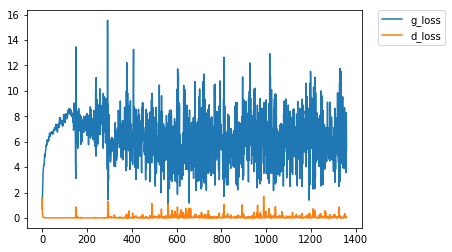

In [19]:
plt.plot(g_losses, label='g_loss')
plt.plot(d_losses, label='d_loss')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### 6.4 Get a normal fake image

(3, 242, 242)


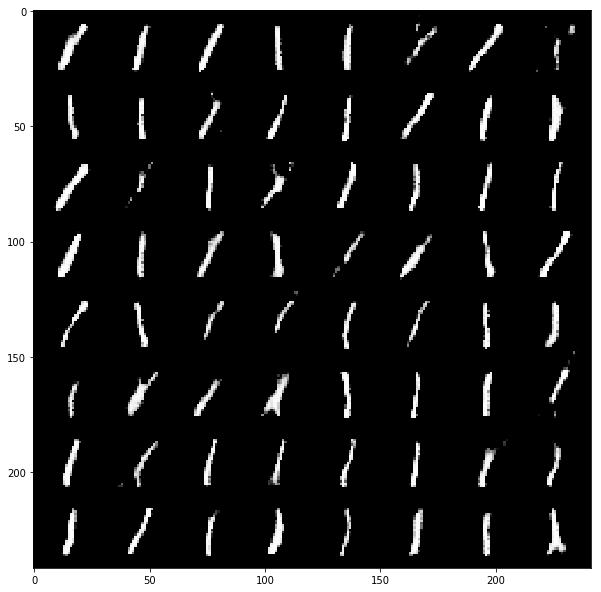

In [23]:
z = torch.randn(64, latent_dim, 1, 1).to(device)
imshow_grid(G(z))

## 7.Train the Encoder izif 

In [24]:
writer = SummaryWriter(logdir='runs/Encoder_training')

img_shape = (channels, img_size, img_size)

E = Encoder(latent_dim, ndf, channels, bias=True).to(device)

G.eval()
D.eval()

criterion = nn.MSELoss()

optimizer_E = torch.optim.Adam(E.parameters(), lr=learning_rate, betas=(b1, b2))

padding_epoch = len(str(n_epochs))
padding_i = len(str(len(train_dataloader)))
kappa = 1.0
e_losses = []

for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(train_dataloader):
        real_imgs = imgs.to(device)
        
        optimizer_E.zero_grad() 
        z = E(real_imgs) # 64, 100
        
        fake_imgs = G(z)

        real_features = D.forward_features(real_imgs)
        fake_features = D.forward_features(fake_imgs)
        # real_feature = real_features / real_features.max()
        # fake_features = fake_features / fake_features.max()

        # izif architecture
        loss_imgs = criterion(fake_imgs, real_imgs)
        loss_features = criterion(fake_features, real_features)
        e_loss = loss_imgs + kappa * loss_features

        e_loss.backward()
        optimizer_E.step()


        if i % n_critic == 0:
            e_losses.append(e_loss)

            writer.add_scalar('e_loss', e_loss.item(), epoch)
            print(f"[Epoch {epoch:{padding_epoch}}/{n_epochs}] "
                    f"[Batch {i:{padding_i}}/{len(train_dataloader)}] "
                    f"[E loss: {e_loss.item():3f}]")
            
#writer.close()
print('Finished Training')

[Epoch  0/40] [Batch   0/169] [E loss: 1.040800]
[Epoch  0/40] [Batch   5/169] [E loss: 0.464492]
[Epoch  0/40] [Batch  10/169] [E loss: 0.338071]
[Epoch  0/40] [Batch  15/169] [E loss: 0.541113]
[Epoch  0/40] [Batch  20/169] [E loss: 0.327886]
[Epoch  0/40] [Batch  25/169] [E loss: 0.360530]
[Epoch  0/40] [Batch  30/169] [E loss: 0.385779]
[Epoch  0/40] [Batch  35/169] [E loss: 0.339990]
[Epoch  0/40] [Batch  40/169] [E loss: 0.257765]
[Epoch  0/40] [Batch  45/169] [E loss: 0.271103]
[Epoch  0/40] [Batch  50/169] [E loss: 0.332729]
[Epoch  0/40] [Batch  55/169] [E loss: 0.264155]
[Epoch  0/40] [Batch  60/169] [E loss: 0.220993]
[Epoch  0/40] [Batch  65/169] [E loss: 0.222395]
[Epoch  0/40] [Batch  70/169] [E loss: 0.205382]
[Epoch  0/40] [Batch  75/169] [E loss: 0.348983]
[Epoch  0/40] [Batch  80/169] [E loss: 0.209854]
[Epoch  0/40] [Batch  85/169] [E loss: 0.202992]
[Epoch  0/40] [Batch  90/169] [E loss: 0.209406]
[Epoch  0/40] [Batch  95/169] [E loss: 0.205452]
[Epoch  0/40] [Batch

### 7.1 Check the fake image using the the "latene vector" from Encoder 

(3, 242, 242)


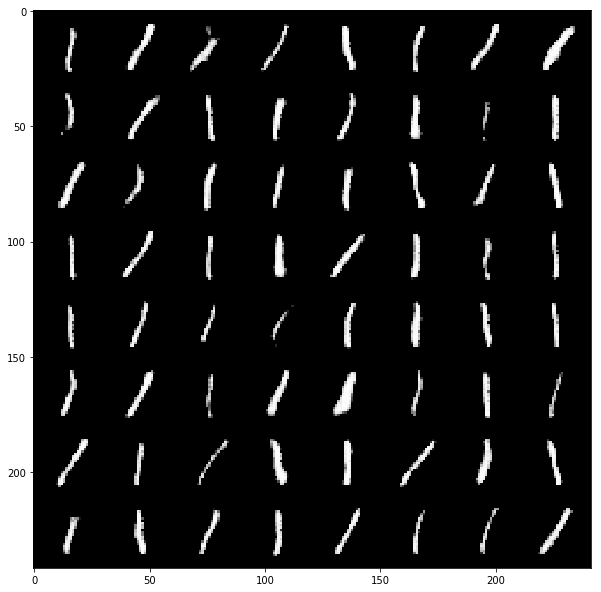

In [25]:
z = torch.randn(64, latent_dim, 1, 1).to(device) # 64, 100
fake_imgs = G(z) # 64, 1, 28, 28
fake_z = E(fake_imgs) #64, 100
reconfiguration_imgs = G(fake_z)

imshow_grid(reconfiguration_imgs)

In [26]:
fake_imgs.shape

torch.Size([64, 1, 28, 28])

In [28]:
fake_z.shape

torch.Size([64, 100, 1, 1])

## 8. Evaluation on Test Dataset

In [30]:
# Image comparision custom fuction
def compare_images(real_img, generated_img, i, score, reverse=False, threshold=50):
    real_img = real_img.cpu().data.numpy().reshape(28, 28) * 255
    generated_img = generated_img.cpu().data.numpy().reshape(28, 28) * 255

    negative = np.zeros_like(real_img)

    if not reverse:
        diff_img = real_img - generated_img
    else:
        diff_img = generated_img - real_img
    
    diff_img[diff_img <= threshold] = 0

    anomaly_img = np.zeros(shape=(28, 28, 3))
    anomaly_img[:, :, 0] = real_img - diff_img
    anomaly_img[:, :, 1] = real_img - diff_img
    anomaly_img[:, :, 2] = real_img - diff_img
    anomaly_img[:, :, 0] = anomaly_img[:,:,0] + diff_img
    anomaly_img = anomaly_img.astype(np.uint8)

    fig, plots = plt.subplots(1, 4)
    fig.suptitle(f'Anomaly - (anomaly score: {score:.4})')
    
    fig.set_figwidth(9)
    fig.set_tight_layout(True)
    plots = plots.reshape(-1)
    plots[0].imshow(real_img, cmap='gray', label='real')
    plots[1].imshow(generated_img, cmap='gray')
    plots[2].imshow(diff_img, cmap='gray')
    plots[3].imshow(anomaly_img)
    
    plots[0].set_title('real')
    plots[1].set_title('generated')
    plots[2].set_title('difference')
    plots[3].set_title('Anomaly Detection')
    plt.show()

In [36]:
#######==============####
# For testing, we will test with the number '1'. 
# So, any other numbers except '1' would be considered abnormal
#######==============####

# Test Data
test_dataset = torchvision.datasets.MNIST('./data', train=False, download=False)

#x_test = torch.cat([x_test_normal[:10], train_dataset.data[train_dataset.targets != 1], test_dataset.data], dim=0)[:20]
#y_test = torch.cat([y_test_normal[:10], train_dataset.targets[train_dataset.targets != 1], test_dataset.targets], dim=0)[:20]
x_test = torch.cat([x_test_normal, train_dataset.data[train_dataset.targets != 1], test_dataset.data], dim=0)
y_test = torch.cat([y_test_normal, train_dataset.targets[train_dataset.targets != 1], test_dataset.targets], dim=0)

test_mnist = SimpleDataset(x_test, y_test,
                            transform=transform)

test_dataloader = DataLoader(test_mnist, batch_size=1, shuffle=False)

1, 0.027990208938717842, 0.03672315925359726, 0.06659674644470215



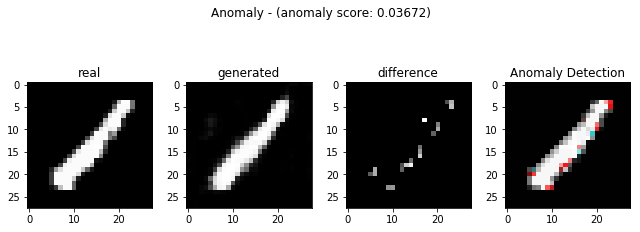

9, 0.15155653655529022, 0.19145888090133667, 0.23955217003822327



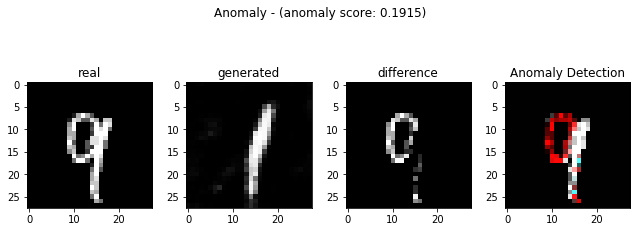

8, 0.24733178317546844, 0.27344775199890137, 0.38171184062957764



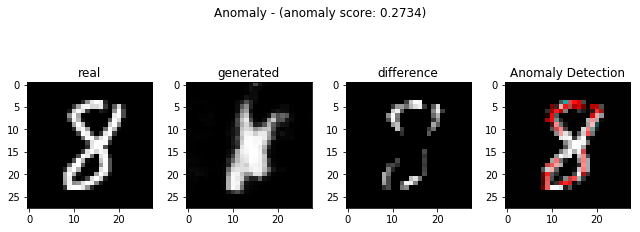

8, 0.32569265365600586, 0.3475708067417145, 0.4103597402572632



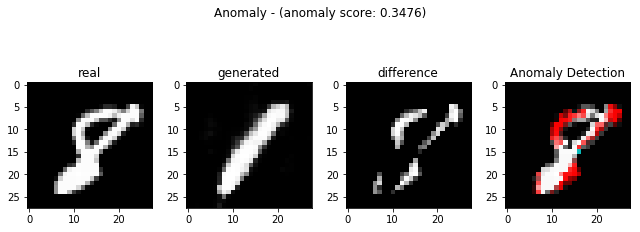

6, 0.4970267117023468, 0.5259261727333069, 0.27426525950431824



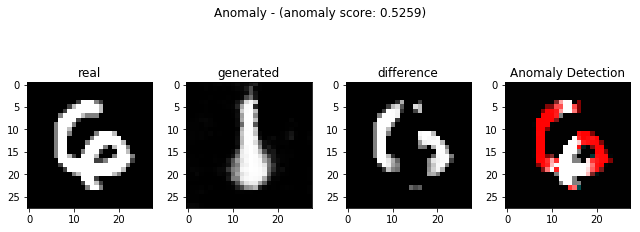

9, 0.16845133900642395, 0.19250823557376862, 0.2570802569389343



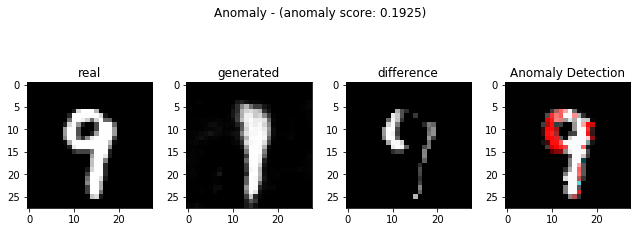

6, 0.2525547444820404, 0.2811591625213623, 0.2645898461341858



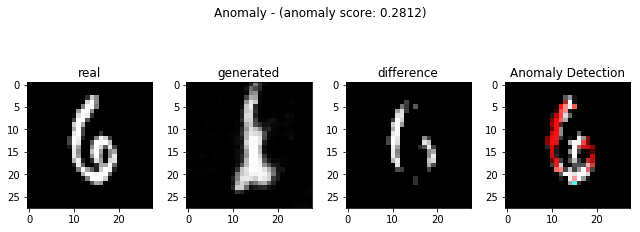

5, 0.22103837132453918, 0.24564068019390106, 0.23796238005161285



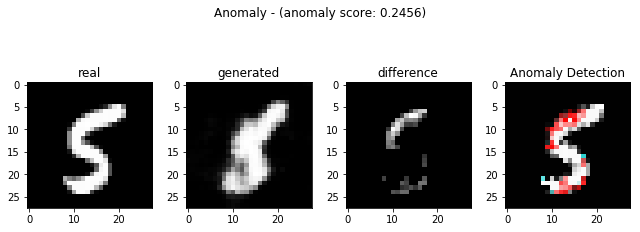

9, 0.32609373331069946, 0.3661534786224365, 0.27958250045776367



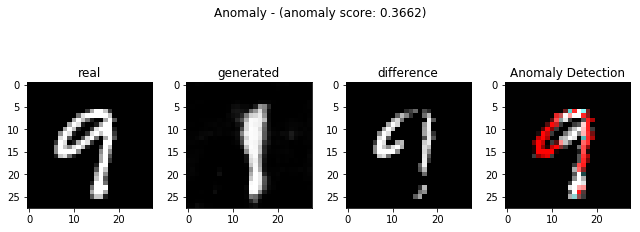

0, 0.3817446827888489, 0.4077450931072235, 0.37872931361198425



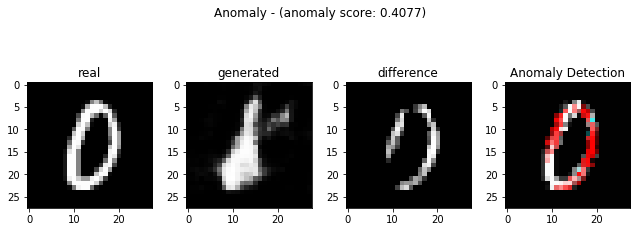

8, 0.1553725302219391, 0.17703671753406525, 0.1995518058538437



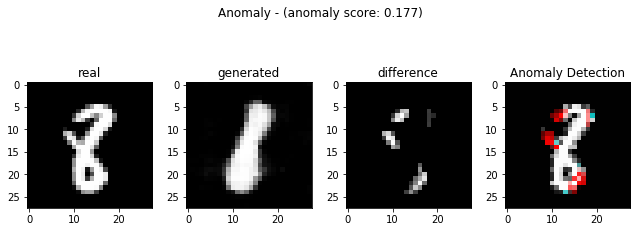

3, 0.2521349787712097, 0.27823343873023987, 0.3679947555065155



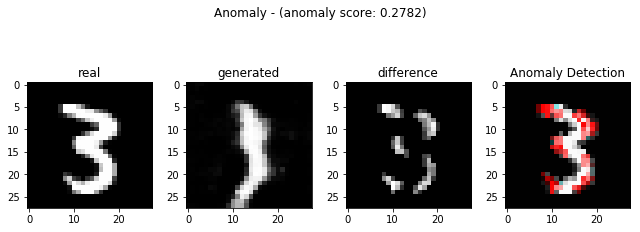

2, 0.5198684334754944, 0.5517836809158325, 0.35870781540870667



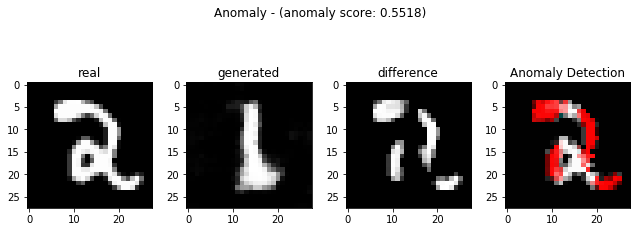

6, 0.3958836793899536, 0.43545782566070557, 0.35111188888549805



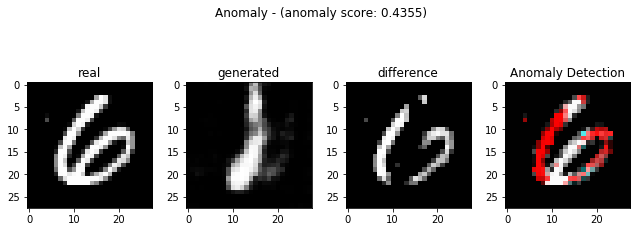

5, 0.18585729598999023, 0.20511364936828613, 0.2426215559244156



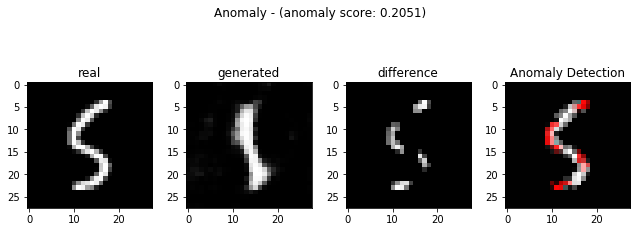

7, 0.2323961853981018, 0.251659631729126, 0.18346278369426727



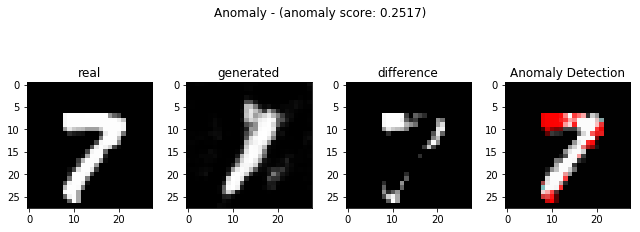

7, 0.406520277261734, 0.43284469842910767, 0.31969472765922546



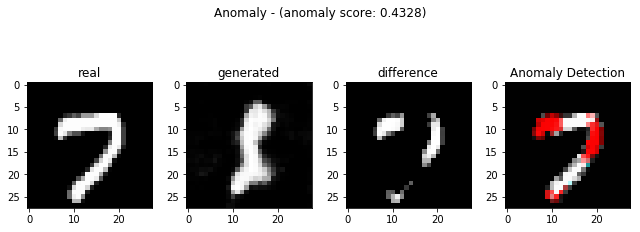

2, 0.20827795565128326, 0.2338770180940628, 0.18612904846668243



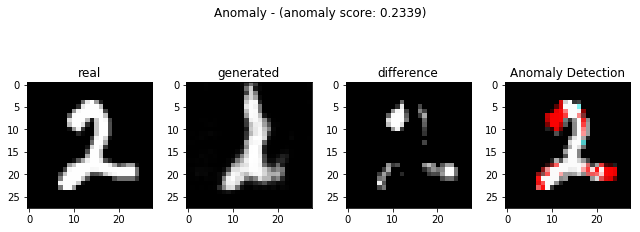

3, 0.46338951587677, 0.5096207857131958, 0.4873062074184418



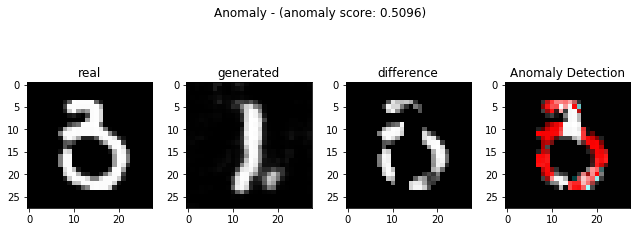

2, 0.49687156081199646, 0.5394697189331055, 0.404358446598053



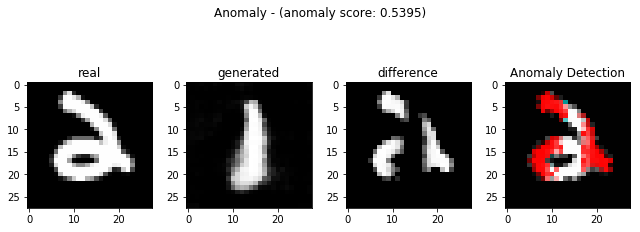

4, 0.283242404460907, 0.33061230182647705, 0.28585049510002136



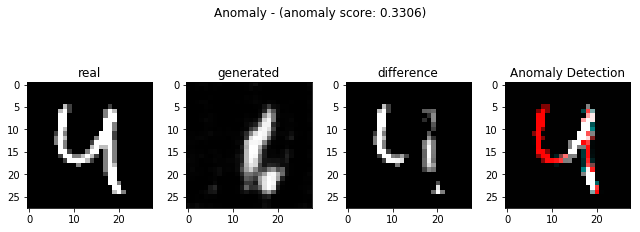

9, 0.29016441106796265, 0.31494060158729553, 0.4981384873390198



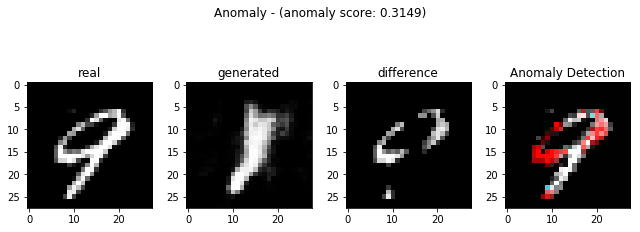

3, 0.19811411201953888, 0.21429027616977692, 0.2491464763879776



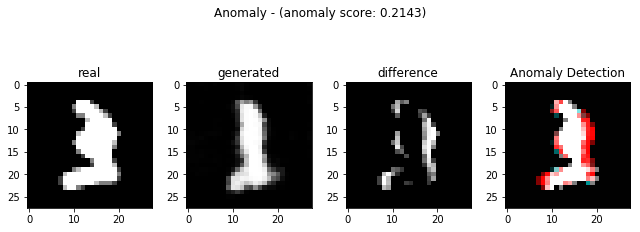

3, 0.39435887336730957, 0.4274456799030304, 0.50370854139328



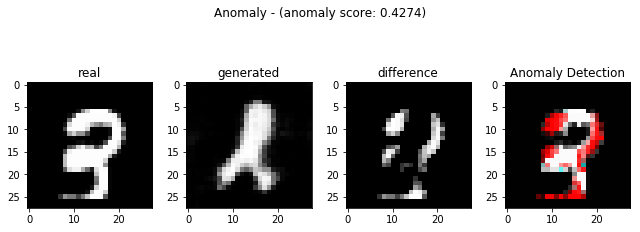

0, 0.6290982365608215, 0.6625223755836487, 0.5369219779968262



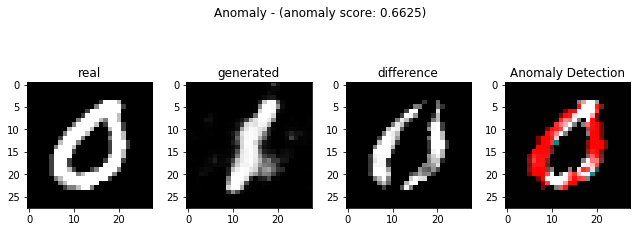

2, 0.15785610675811768, 0.17647944390773773, 0.2510339617729187



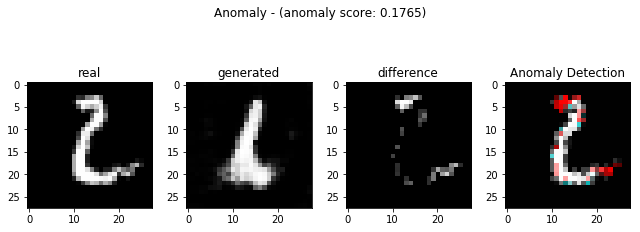

8, 0.19935183227062225, 0.23461779952049255, 0.45253679156303406



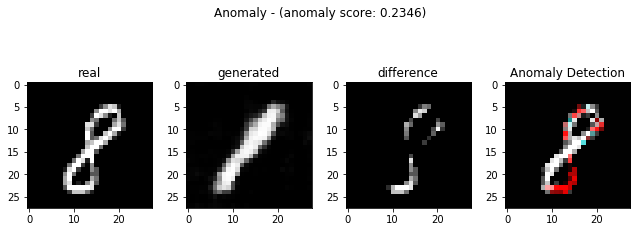

7, 0.2187727838754654, 0.23753967881202698, 0.22613981366157532



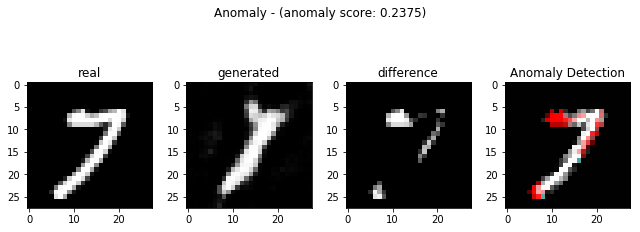

5, 0.31464797258377075, 0.34605422616004944, 0.3629288077354431



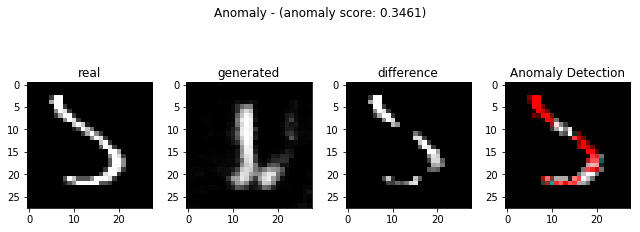

5, 0.4049098789691925, 0.42952531576156616, 0.47230803966522217



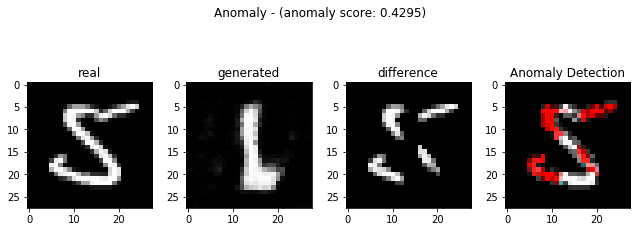

4, 0.2846514582633972, 0.3190081715583801, 0.2866652309894562



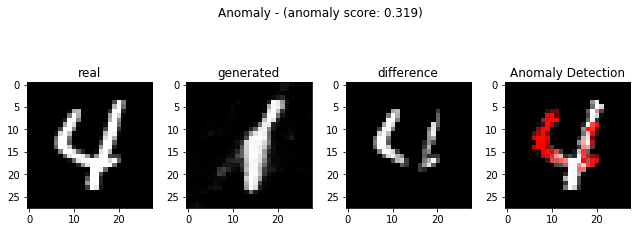

5, 0.36256104707717896, 0.3948909342288971, 0.42462486028671265



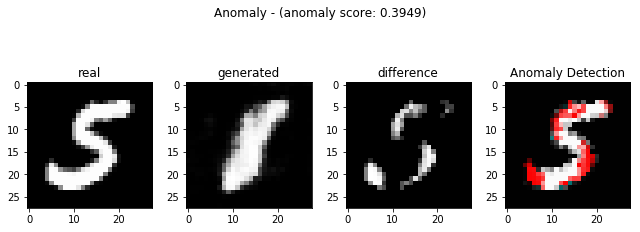

7, 0.4604218900203705, 0.49670594930648804, 0.5135849118232727



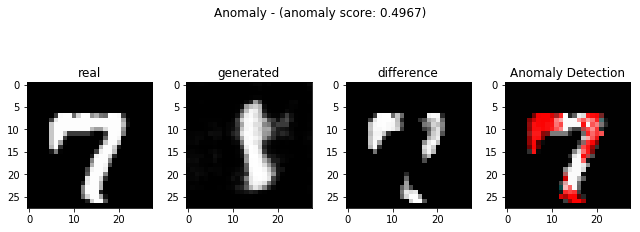

In [37]:
criterion = nn.MSELoss()

G.eval()
D.eval()
E.eval()

with open("score.csv", "w") as f:
        f.write("label,img_distance,anomaly_score,z_distance\n")

for i, (img, label) in enumerate(test_dataloader):
    real_img = img.to(device)

    real_z = E(real_img) # 진짜 이미지의 latent vector
    fake_img = G(real_z) # G에 넣어서 가짜 이미지 생성.
    fake_z = E(fake_img) # torch.Size([1, 100]) --> latent 진짜 이미지와 매핑된 가짜 이미지의 latent vector

    real_feature = D.forward_features(real_img) # 1, 256
    fake_feature = D.forward_features(fake_img)
    real_feature = real_feature / real_feature.max()
    fake_feature = fake_feature / fake_feature.max()
    # print("real_feature max : ",real_feature.max())
    # print("real_feature min : ",real_feature.min())
    # print("fake_feature max : ",fake_feature.max())
    # print("fake_feature min : ",fake_feature.min())

    img_distance = criterion(fake_img, real_img)
    loss_feature = criterion(fake_feature, real_feature)

    anomaly_score = img_distance + kappa*loss_feature

    z_distance = criterion(fake_z, real_z)
    
    with open("score.csv", "a") as f:
            f.write(f"{label.item()},{img_distance},"
                    f"{anomaly_score},{z_distance}\n")
    
    if i % 2000 == 0:
        print(f"{label.item()}, {img_distance}, "
          f"{anomaly_score}, {z_distance}\n")
        compare_images(real_img, fake_img,i, anomaly_score, reverse = False, threshold = 80)

## 9. Visualization

In [38]:
path = 'C:\\Users\\bokhy\\Desktop\\Python\\python-projects\\Pytorch\\'
df = pd.read_csv(os.path.join(path, 'score.csv'))
df

,label,img_distance,anomaly_score,z_distance
0,1,0.027990,0.036723,0.066597
1,1,0.009685,0.019196,0.016060
2,1,0.004668,0.010490,0.013610
3,1,0.015226,0.020732,0.019049
4,1,0.019169,0.025242,0.028067
...,...,...,...,...
64602,2,0.363916,0.385670,0.259537
64603,3,0.388917,0.427220,0.393049
64604,4,0.216015,0.240710,0.213918
64605,5,0.224669,0.262801,0.187279


In [39]:
trainig_label = 1 # We want to see numeric value '1'

labels = np.where(df["label"].values == trainig_label, 0, 1)
anomaly_score = df["anomaly_score"].values
img_distance = df["img_distance"].values
z_distance = df["z_distance"].values

In [40]:
fpr, tpr, _ = roc_curve(labels, img_distance)
precision, recall, _ = precision_recall_curve(labels, img_distance)
roc_auc = auc(fpr, tpr)
pr_auc =  auc(recall, precision)

### 9.1. Image-level anomaly-detection Accuracy (FP/TP graph and precision/recall graph)

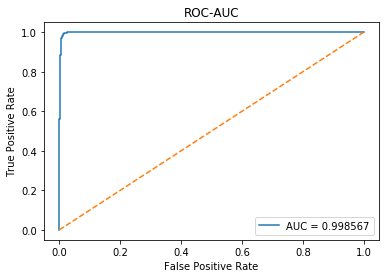

In [41]:
# FP/TP graph
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.title("ROC-AUC")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

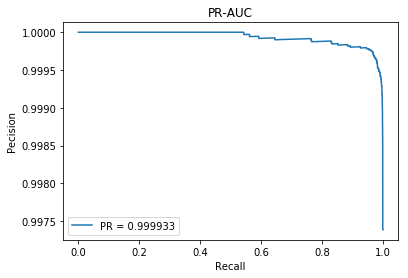

In [42]:
# precision/recall graph
plt.plot(recall, precision, label=f"PR = {pr_auc:3f}")
plt.title("PR-AUC")
plt.xlabel("Recall")
plt.ylabel("Pecision")
plt.legend()
plt.show()

In [43]:
### 9.2 .Distributions of anomaly scores

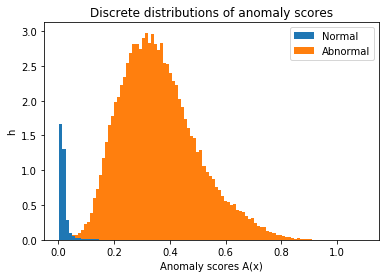

In [44]:
plt.hist([anomaly_score[labels == 0], anomaly_score[labels == 1]],
          bins=100, density=True, stacked=True,
          label=["Normal", "Abnormal"])
plt.title("Discrete distributions of anomaly scores")
plt.xlabel("Anomaly scores A(x)")
plt.ylabel("h")
plt.legend()
plt.show()